epoch : 01, train_loss : 0.7264707848782669, train_acc : 0.8206165397631133
epoch : 02, train_loss : 0.14416043290178182, train_acc : 0.961812605752961
epoch : 03, train_loss : 0.09295435517383409, train_acc : 0.9734507191201355
epoch : 04, train_loss : 0.07034585867849275, train_acc : 0.9801713197969543
epoch : 05, train_loss : 0.05782319206741281, train_acc : 0.9834496615905245
epoch : 06, train_loss : 0.04917678281084938, train_acc : 0.9861304991539763
epoch : 07, train_loss : 0.04326408351661225, train_acc : 0.9877062182741116
epoch : 08, train_loss : 0.03839965085199579, train_acc : 0.9894775803722504
epoch : 09, train_loss : 0.03450752018837419, train_acc : 0.9901649746192893
epoch : 10, train_loss : 0.030221708701583107, train_acc : 0.9914868866328257
epoch : 11, train_loss : 0.028127646434271326, train_acc : 0.9917882825719121
epoch : 12, train_loss : 0.025113480087990563, train_acc : 0.9929251269035534
epoch : 13, train_loss : 0.02305652368874817, train_acc : 0.993681260575296

D:\Anaconda\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 36724 missing from current font.
  font.set_text(s, 0, flags=flags)


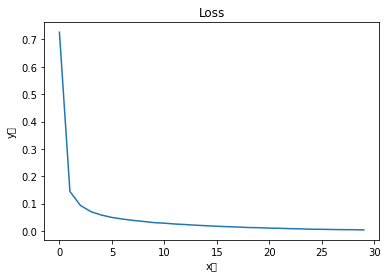

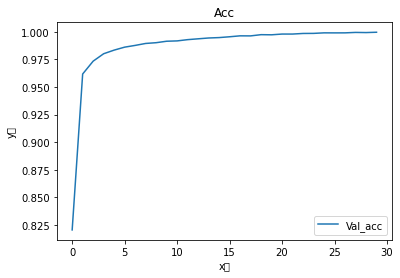

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

class DigitSet(Dataset) :
    def __init__(self, path, model = 'train') :
        super().__init__()
        self.model = model
        with open(path) as file :
            data_csv = list(csv.reader(file))
            data = np.array(data_csv[1 : ]).astype(np.float32)
        if self.model == 'test' :
            self.data = torch.FloatTensor(data.reshape(len(data), 1, 28, 28))
        else :
            target = data[ : , 0]
            data = data[ : , 1 : ]
            train_index = []
            val_index = []
            for i in range(data.shape[0]) :
                if i % 10 != 0 :
                    train_index.append(i)
                else :
                    val_index.append(i)
            if model == 'train' :
                self.data = torch.FloatTensor(data[train_index, : ].reshape(len(train_index), 1, 28, 28))
                self.target = torch.LongTensor(target[train_index])
            else :
                self.data = torch.FloatTensor(data[val_index, : ].reshape(len(val_index), 1, 28, 28))
                self.target = torch.LongTensor(target[val_index])
        self.data = self.data / 255
        #self.data = (self.data - self.data.mean(dim = 0)) / self.data.std(dim = 0)
        #print(self.data)
        self.dim = data.shape[1]
    def __getitem__(self, item) :
        if self.model == 'train' or self.model == 'val' :
            return self.data[item], self.target[item]
        else :
            return self.data[item]
    def __len__(self) :
        return len(self.data)
class Classifier(nn.Module) :
    def __init__(self) :
        super(Classifier, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  

            nn.Conv2d(16, 32, 3, 1, 1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  
        )
        self.net = nn.Sequential(
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),)
    def forward(self, x) :
        output = self.CNN(x)
        output = output.view(output.size(0), -1)
        return self.net(output)

Batch_size = 64
train_set = DigitSet('train.csv', model = 'train')
val_set = DigitSet('train.csv', model = 'val')
test_set = DigitSet('test.csv', model = 'test')

train_loader = DataLoader(train_set, batch_size=Batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=Batch_size,shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=Batch_size, shuffle=False, drop_last=False)

model = Classifier().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
max_epoch = 30
train_losses = []
val_acces = []

for epoch in range(max_epoch) :
    train_loss = 0.0
    train_acc = 0.0
    min_loss = 1000
    model.train()
    for x, label in train_loader :
        x, label = x.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, label)
        #train_losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, pred = output.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / x.shape[0]
        #train_acces.append(acc)
        train_acc += acc
    total_loss = []
    with torch.no_grad() :
        model.eval()
        for y, data in enumerate(val_loader) :
            x, label = data[0].cuda(), data[1].cuda()
            output = model(x)
            total_loss.append(criterion(output, label))
            dev_loss = sum(total_loss) / len(total_loss)
    if dev_loss < min_loss :
        min_loss = dev_loss
        torch.save(model.state_dict(), 'mymodel.pth')
    print('epoch : {:02d}, train_loss : {}, train_acc : {}'.format(epoch + 1, 
                                                               train_loss / len(train_loader), 
                                                               train_acc  / len(train_loader)))
    train_losses.append(train_loss / len(train_loader))
    val_acces.append(train_acc  / len(train_loader))
del model
bestmodel = Classifier().cuda()
ckpt = torch.load('mymodel.pth', map_location="cpu")
bestmodel.load_state_dict(ckpt)
with torch.no_grad() :
    bestmodel.eval()
    output = []
    for x in test_loader :
        x = x.cuda()
        out = bestmodel(x)
        _, pred = torch.max(out, 1)
        for i in pred.cpu().numpy():
            output.append(i)
    #output = torch.cat(output, dim = 0).data.cpu().numpy()
with open('prediction.csv', 'w') as file :
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    for i, pred in enumerate(output) :
        writer.writerow([i, pred])
epoch = list(range(30))
plt.figure('figure one')
plt.plot(epoch, train_losses, label = 'Train_loss')
plt.xlabel('x轴')
plt.ylabel('y轴')
plt.title('Loss')
plt.figure('figure two')
plt.plot(epoch, val_acces, label = 'Val_acc')
plt.xlabel('x轴')
plt.ylabel('y轴')
plt.title('Acc')
plt.legend()
plt.show()